#Transfer Learning

##Dogs vs. Cats
Create an algorithm to distinguish dogs from cats

https://www.kaggle.com/c/dogs-vs-cats


To download dataset directly from Kaggle:
https://www.kaggle.com/general/51898



## Famous Architeture (VGG16):
- raw whole architecture + random (He) initialization --> re-train*
- the whole architecture + pre-trained weights (imagenet)
- the whole architecture + pre-trained weights --> re-train
- a featurizer part of architecture (include_top = False)
  - top --> ML/DL-based classifier/regressor --> re-train
  - part of classifier or part of featurizer --> include_top=True,  trainable = F/T in a loop



\* re-train --> model.fit(own_dataset)

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:03<00:00, 270MB/s]
100% 812M/812M [00:03<00:00, 226MB/s]


In [ ]:
#Unzip the dataset and set the path to the training and test set.
with zipfile.ZipFile('dogs-vs-cats.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dogs-vs-cats')

with zipfile.ZipFile('dogs-vs-cats/train.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dogs-vs-cats')

with zipfile.ZipFile('dogs-vs-cats/test1.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/dogs-vs-cats')

base_dir = '/content/dogs-vs-cats'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test1')

In [ ]:
n_train = len(os.listdir(train_dir))
n_test = len(os.listdir(test_dir))

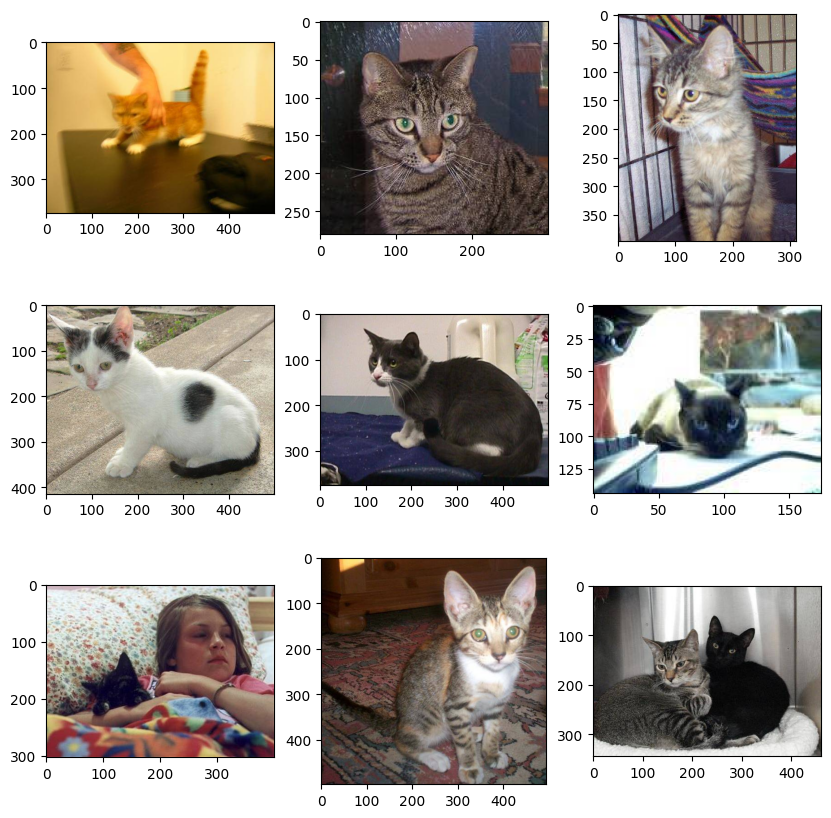

In [ ]:
# plot first few images
plt.figure(figsize=(10, 10))
for i in range(9):
	# define subplot
	plt.subplot(331 + i)
	# define filename
	filename = train_dir + '/cat.' + str(i) + '.jpg'
	# load image pixels
	image = plt.imread(filename)
	# plot raw pixel data
	plt.imshow(image)
# show the figure
plt.show()

In [ ]:
#load the images from their location.
from tensorflow.keras.utils import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,
                                            shuffle=True,
                                            batch_size=4,
                                            image_size=(150, 150))
test_dataset = image_dataset_from_directory(test_dir,
                                           shuffle=True,
                                           batch_size=4,
                                           image_size=(150, 150))

### Continue with tensorflow cat-dog dataset

In [ ]:
#gpu
from tensorflow import config
physical_devices = config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
import tensorflow_datasets as tfds

#Disables Tqdm progress bar.
# tfds.disable_progress_bar()

#load dataset
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:20%]", "train[20%:25%]", "train[25%:30%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompletePXPFT6/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of training samples: 4652
Number of validation samples: 1164
Number of test samples: 1163


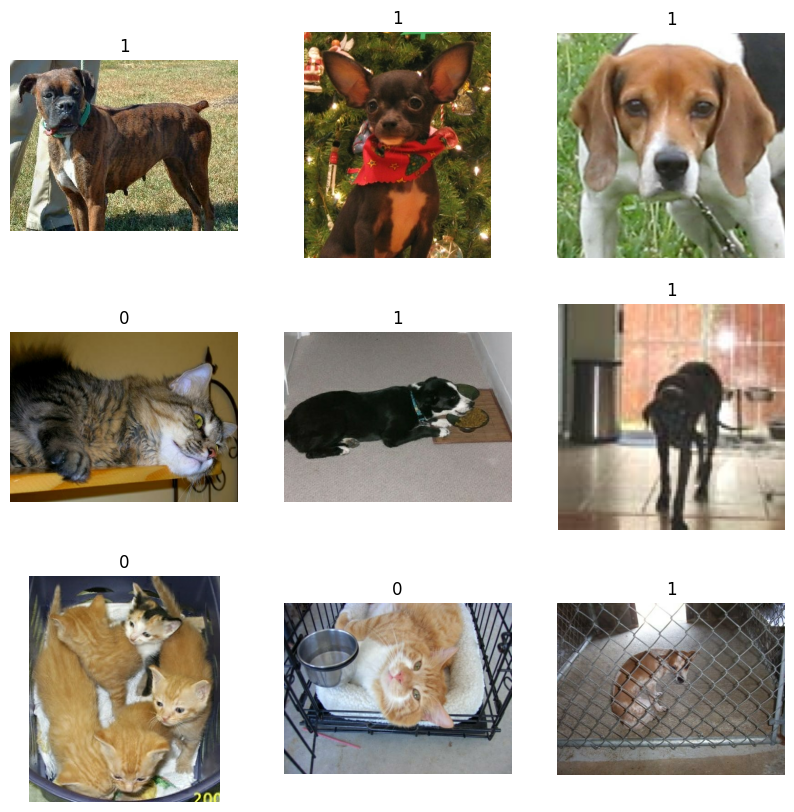

In [ ]:
#display some images from dataset
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

### Data pre-processing and augmentation

Whereas data pre-processing isn’t a specific step in transfer learning, it is an important step in training machine learning models in general. Let’s, therefore, apply some augmentation to the images. When you apply augmentation to a training set, you’re preventing overfitting, because augmentation exposes different aspects of the image to the model.

You can augment it using various transformations, like:

* random rotations,
* horizontal flipping,
* zooming,
* shearing.

You can apply these transformations when loading the data.



In [ ]:
#data prepration
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
#system setup
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
data_augmentation = keras.Sequential(
    [keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
     keras.layers.experimental.preprocessing.RandomRotation(0.1),
     keras.layers.experimental.preprocessing.RandomZoom(0.05, 0.05, fill_mode='nearest')]
     )

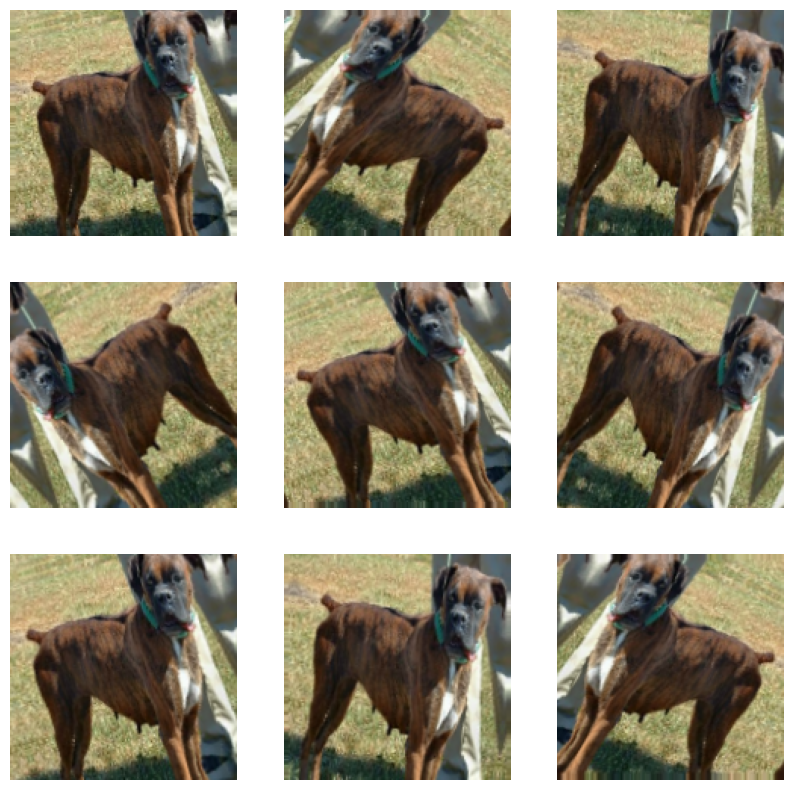

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [ ]:
#Create a base model from the pre-trained VGG model
base_model = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained VGG weights requires that input be normalized
# This model expects data in the range of (-1,1) and not (0,1).
x = tf.keras.applications.vgg16.preprocess_input(x)


# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Freeze the base model layers so that they’re not updated during the training process.

Since many pre-trained models have a `tf.keras.layers.BatchNormalization` layer, it’s important to freeze those layers. Otherwise, the layer mean and variance will be updated, which will destroy what the model has already learned. Let’s freeze all the layers in this case.

In [ ]:
#Train the model
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 5
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
146/146 [==============================] - 23s 105ms/step - loss: 0.9339 - binary_accuracy: 0.8356 - val_loss: 0.3198 - val_binary_accuracy: 0.9381
Epoch 2/5
146/146 [==============================] - 13s 90ms/step - loss: 0.4219 - binary_accuracy: 0.9048 - val_loss: 0.2281 - val_binary_accuracy: 0.9485
Epoch 3/5
146/146 [==============================] - 13s 90ms/step - loss: 0.3416 - binary_accuracy: 0.9202 - val_loss: 0.1892 - val_binary_accuracy: 0.9588
Epoch 4/5
146/146 [==============================] - 13s 88ms/step - loss: 0.2923 - binary_accuracy: 0.9288 - val_loss: 0.1720 - val_binary_accuracy: 0.9639
Epoch 5/5
146/146 [==============================] - 13s 88ms/step - loss: 0.2634 - binary_accuracy: 0.9329 - val_loss: 0.1531 - val_binary_accuracy: 0.9656


In [ ]:
#items in history
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

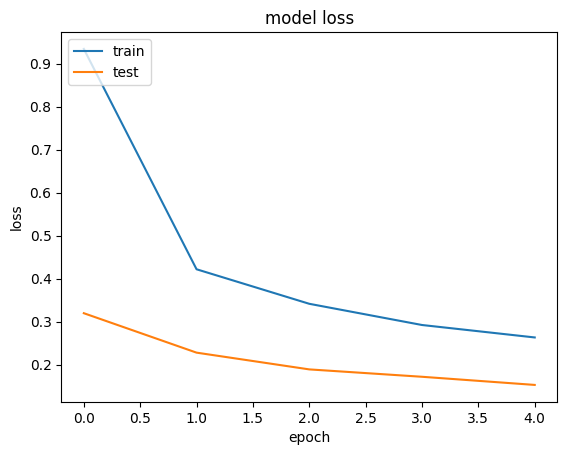

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

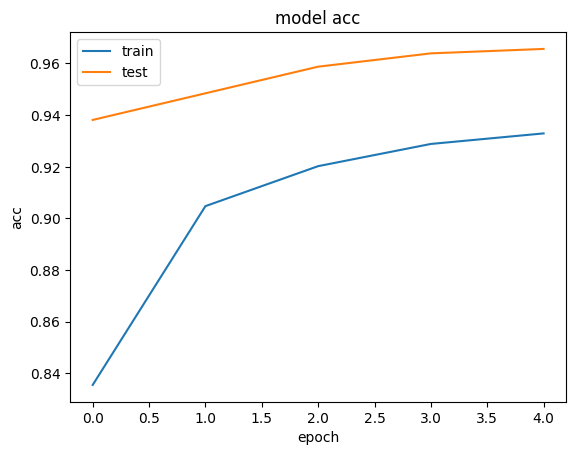

In [ ]:
# summarize history for loss
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Fine-tuning the model
The model can be improved by unfreezing the base model, and retraining it on a very low learning rate.

You need to monitor this step because the wrong implementation can lead to overfitting. First, unfreeze the base model.
Unfreeze the base_model. Note that it keeps running in inference mode since we passed `training=False` when calling it. This means that the batchnorm layers will not update their batch statistics. This prevents the batchnorm layers from undoing all the training we've done so far.

### Fine Tunning

In [ ]:
#Fine-tuning the model
base_model.trainable = True
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0   

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 5
history2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
146/146 [==============================] - 50s 257ms/step - loss: 0.1773 - binary_accuracy: 0.9364 - val_loss: 0.0979 - val_binary_accuracy: 0.9708
Epoch 2/5
146/146 [==============================] - 34s 234ms/step - loss: 0.1066 - binary_accuracy: 0.9527 - val_loss: 0.0878 - val_binary_accuracy: 0.9716
Epoch 3/5
146/146 [==============================] - 34s 232ms/step - loss: 0.0752 - binary_accuracy: 0.9706 - val_loss: 0.1463 - val_binary_accuracy: 0.9467
Epoch 4/5
146/146 [==============================] - 34s 231ms/step - loss: 0.0672 - binary_accuracy: 0.9729 - val_loss: 0.0851 - val_binary_accuracy: 0.9674
Epoch 5/5
146/146 [==============================] - 34s 232ms/step - loss: 0.0414 - binary_accuracy: 0.9828 - val_loss: 0.1268 - val_binary_accuracy: 0.9699


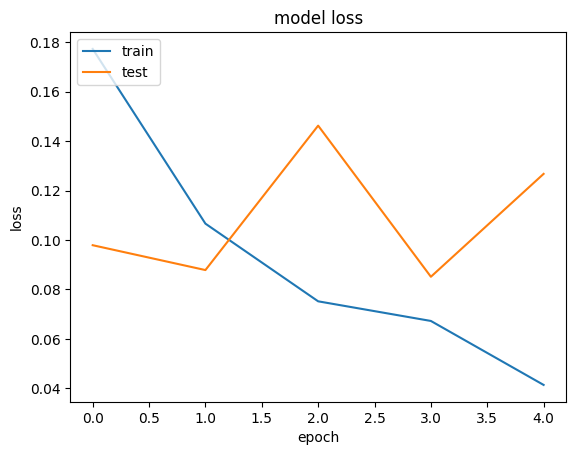

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# in case need to have predicted labels (now, we don't need it)
predictions = model.predict(test_ds)

37/37 [==============================] - 5s 130ms/step


In [ ]:
# Evaluate the best model with testing data.
print(model.evaluate(x=test_ds))

37/37 [==============================] - 3s 68ms/step - loss: 0.0468 - binary_accuracy: 0.9819
[0.04683082923293114, 0.9819432497024536]


### another approach

In [ ]:
#Create a base model from the pre-trained VGG model
base_model = keras.applications.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Freeze the base_model
set_trainable = False
for lyr in base_model.layers:
  if lyr.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    lyr.trainable = True
  else:
    lyr.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained VGG weights requires that input be normalized
# This model expects data in the range of (-1,1) and not (0,1).
x = tf.keras.applications.vgg16.preprocess_input(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 150, 150, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 150, 150, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0   

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()]
)

epochs = 5
history3 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
146/146 [==============================] - 17s 101ms/step - loss: 0.8358 - binary_accuracy: 0.8095 - val_loss: 0.2192 - val_binary_accuracy: 0.9253
Epoch 2/5
146/146 [==============================] - 15s 102ms/step - loss: 0.2261 - binary_accuracy: 0.9095 - val_loss: 0.1589 - val_binary_accuracy: 0.9459
Epoch 3/5
146/146 [==============================] - 15s 103ms/step - loss: 0.1673 - binary_accuracy: 0.9357 - val_loss: 0.1482 - val_binary_accuracy: 0.9519
Epoch 4/5
146/146 [==============================] - 15s 102ms/step - loss: 0.1300 - binary_accuracy: 0.9458 - val_loss: 0.1289 - val_binary_accuracy: 0.9605
Epoch 5/5
146/146 [==============================] - 15s 102ms/step - loss: 0.1184 - binary_accuracy: 0.9531 - val_loss: 0.1184 - val_binary_accuracy: 0.9639


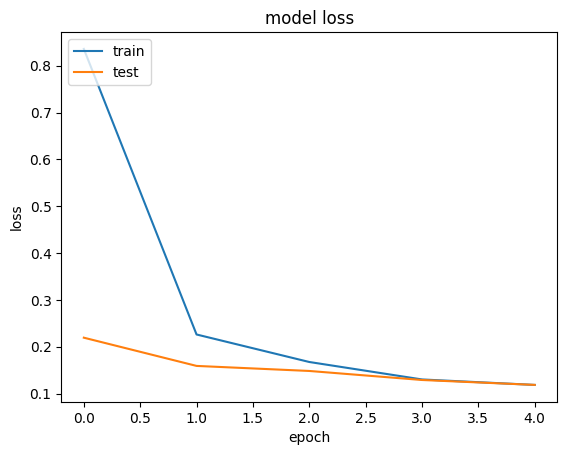

In [ ]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()